### tables:
1. Pacients (Пациент)
2. PacientStats (Измерения показатилей пациента)
3. HospitalStats (Целевые переменные)

In [21]:
import os

import pandas as pd
import numpy as np
import collections

import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Formation table: HospitalStats

Формируем таблицу с целевыми переменными с полями:

1. RecordID - уникальный идентификационный номер пациента
2. Survival - целевая переменная, содержит информацию сколько дней прожил пациент после попадания в отделение интенсивной терапии (например, 575б 918, 5 и т. д.), -1 означает что пациент жив до сих пор.
3. In-hospital_death - целевая переменная, содержит информацию умер человек в отделение интенсивной терапии (1) или нет (0).

In [3]:
outcomes = pd.read_csv('data/Outcomes.csv')

In [4]:
outcomes.head()

,RecordID,Survival,In-hospital_death
0,132539,-1,0
1,132540,-1,0
2,132541,-1,0
3,132543,575,0
4,132545,918,0


## Formation table: Pacients

У пациента будут поля:

1. RecordID - уникальный идентификационный номер пациента.
2. Age - возраст пациента в годах.
3. Gender - пол пациента (0: female, or 1: male).
4. Height - рост пациента в сантиметрах.
5. ICUType - тип отделения интенсивной терапии куда был доставлен пациент (1: Coronary Care Unit, 2: Cardiac Surgery Recovery Unit, 3: Medical ICU, or 4: Surgical ICU).
6. Weight - вес пациента в киллограммах (Обратите внимание, что вес является как общим дескриптором (записывается при поступлении), так и переменной временного ряда (часто измеряется ежечасно для оценки баланса жидкости)).

Меняем формат всех файлов в папке "data/set" с .txt на .csv

In [5]:
for root, dirs, files in os.walk("./data/set"):
    for filename in files:
        base = os.path.splitext(filename)[0]
        os.rename(f'./data/set/{filename}', f'./data/set/{base}.csv')

In [6]:
datas = {}
recordID_list = []

for root, dirs, files in os.walk("./data/set"):
    for filename in files:
        recordID = os.path.splitext(filename)[0]
        datas[recordID] = pd.read_csv(f'./data/set/{filename}')
        recordID_list.append(recordID)

In [7]:
datas[recordID_list[0]]

,Time,Parameter,Value
0,00:00,RecordID,132539.00
1,00:00,Age,54.00
2,00:00,Gender,0.00
3,00:00,Height,-1.00
4,00:00,ICUType,4.00
...,...,...,...
268,47:37,NIMAP,79.33
269,47:37,NISysABP,128.00
270,47:37,RespRate,23.00
271,47:37,Temp,37.80


In [8]:
users_stats_df = [datas[idx] for idx in recordID_list]
params = pd.concat(users_stats_df, ignore_index=True)

params = list(params['Parameter'])
chart_data = dict(collections.Counter(params))

chart_data = pd.DataFrame([chart_data])
lim_up = max(chart_data.values.tolist()[0])

In [9]:
main = {param: chart_data[param].iloc[0] for param in chart_data.columns if chart_data[param].iloc[0] == 8000}
main['Weight'] = 0
main = main.keys()
pd.DataFrame([{"Основные характеристики": h} for h in main])

,Основные характеристики
0,RecordID
1,Age
2,Gender
3,Height
4,ICUType
5,Weight


In [10]:
patients_cols = main
patients = pd.DataFrame(columns = patients_cols)
patients

,RecordID,Age,Gender,Height,ICUType,Weight


In [11]:
for recordID in recordID_list:
    row = {}
    for col in patients_cols:
        row[col] = datas[recordID][datas[recordID]['Parameter'] == col]['Value'].values[-1:][0]
    patients = patients.append(pd.DataFrame([row]), ignore_index=True)

In [12]:
patients

,RecordID,Age,Gender,Height,ICUType,Weight
0,132539.0,54.0,0.0,-1.0,4.0,-1.0
1,132540.0,76.0,1.0,175.3,2.0,81.6
2,132541.0,44.0,0.0,-1.0,3.0,56.7
3,132543.0,68.0,1.0,180.3,3.0,84.6
4,132545.0,88.0,0.0,-1.0,3.0,-1.0
...,...,...,...,...,...,...
7995,152849.0,78.0,1.0,180.3,2.0,87.5
7996,152851.0,90.0,1.0,177.8,3.0,87.4
7997,152858.0,70.0,0.0,152.4,2.0,79.3
7998,152862.0,49.0,0.0,-1.0,3.0,57.0


## Formation table: PacientStats

Таблица с показателями пациентов (по времени снятия показателей):

1. Albumin (g/dL).
2. ALP [Alkaline phosphatase (IU/L)].
3. ALT [Alanine transaminase (IU/L)].
4. AST [Aspartate transaminase (IU/L)].
5. Bilirubin (mg/dL).
6. BUN [Blood urea nitrogen (mg/dL)].
7. Cholesterol (mg/dL).
8. Creatinine [Serum creatinine (mg/dL)].
9. DiasABP [Invasive diastolic arterial blood pressure (mmHg)].
10. FiO2 [Fractional inspired O2 (0-1)].
11. GCS [Glasgow Coma Score (3-15)].
12. Glucose [Serum glucose (mg/dL)].
13. HCO3 [Serum bicarbonate (mmol/L)].
14. HCT [Hematocrit (%)].
15. HR [Heart rate (bpm)].
16. K [Serum potassium (mEq/L)].
17. Lactate (mmol/L).
18. Mg [Serum magnesium (mmol/L)].
19. MAP [Invasive mean arterial blood pressure (mmHg)].
20. MechVent [Mechanical ventilation respiration (0:false, or 1:true)].
21. Na [Serum sodium (mEq/L)].
22. NIDiasABP [Non-invasive diastolic arterial blood pressure (mmHg)].
23. NIMAP [Non-invasive mean arterial blood pressure (mmHg)].
24. NISysABP [Non-invasive systolic arterial blood pressure (mmHg)].
25. PaCO2 [partial pressure of arterial CO2 (mmHg)].
26. PaO2 [Partial pressure of arterial O2 (mmHg)].
27. pH [Arterial pH (0-14)].
28. Platelets (cells/nL).
29. RespRate [Respiration rate (bpm)].
30. SaO2 [O2 saturation in hemoglobin (%)].
31. SysABP [Invasive systolic arterial blood pressure (mmHg)].
32. Temp [Temperature (°C)].
33. TropI [Troponin-I (μg/L)].
34. TropT [Troponin-T (μg/L)].
35. Urine [Urine output (mL)].
36. WBC [White blood cell count (cells/nL)].
37. Weight (kg).

+

38. RecordID - индентификатор пациента
39. Time - время снятия показателей

Таски:

1. Избавляемся от основных показателей из временного ряда
2. Выстраиваем строки в таблице в соответсвии с временем снятия показателей
3. Заполняем пропуски по соседним полям для использования приблезительно точные значения

Общее кол-во значений по времянной шкале не равное 8000 (кол-ву пользователей)

параметры значения которых большее 20%

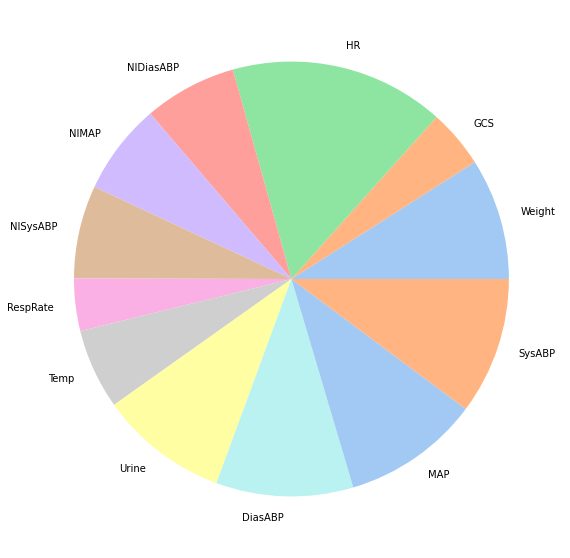

In [13]:
cd_1 = {param: chart_data[param].iloc[0] for param in chart_data.columns
        if chart_data[param].iloc[0] > lim_up*0.2 and chart_data[param].iloc[0] != 8000}
cd = pd.DataFrame([cd_1])
colors = sns.color_palette('pastel')[:len(cd.iloc[0].values.tolist())]

plt.rcParams["figure.figsize"] = (10, 10)
plt.pie(cd.values.tolist()[0], labels=cd.columns, colors=colors)
plt.show()

параметры значание вхождений которых меньше 20%

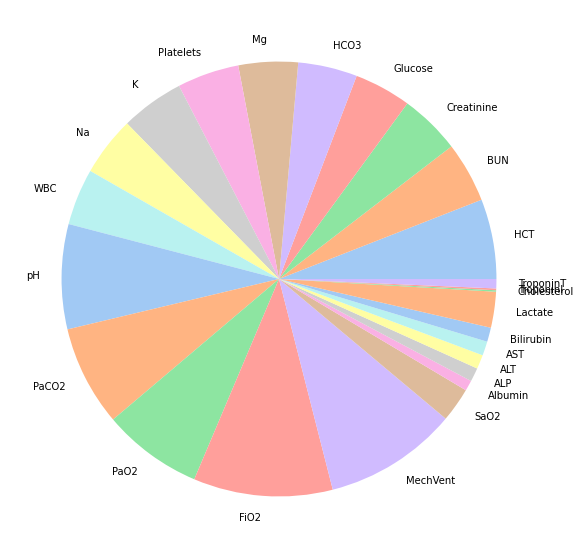

In [14]:
cd_2 = {param: chart_data[param].iloc[0] for param in chart_data.columns
        if chart_data[param].iloc[0] < lim_up*0.2 and chart_data[param].iloc[0] != 8000}
cd = pd.DataFrame([cd_2])
color = sns.color_palette('pastel')[:len(cd.iloc[0].values.tolist())]

plt.rcParams["figure.figsize"] = (10, 10)
plt.pie(cd.values.tolist()[0], labels=cd.columns, colors=colors)
plt.show()

# Work with the database

In [16]:
engine = create_engine('sqlite:///db.sqlite')

In [17]:
engine.execute("""
drop table if exists patients
""")
print("База очищена")

База очищена


In [18]:
engine.execute("""
create table if not exists patients (
    RecordID INTEGER PRIMARY KEY NOT NULL,
    Age INTEGER,
    Gender INTEGER,
    Height FLOAT,
    ICUType INTEGER,
    Weight FLOAT
);
""")

In [19]:
table_name = 'patients'
columns_list = list(main)
columns_names = str(columns_list).replace('[', '').replace(']', '')
injections = str(['?' for i in columns_list]).replace('[', '').replace(']', '').replace("'", '')

for value in patients.values:
    engine.execute(
        f"INSERT INTO {table_name} ({columns_names}) VALUES ({injections})",
        [value]
    )

In [20]:
engine.execute("""
    select * from patients
""").fetchall()[:10]

[(132539, 54, 0, -1.0, 4, -1.0),
 (132540, 76, 1, 175.3, 2, 81.6),
 (132541, 44, 0, -1.0, 3, 56.7),
 (132543, 68, 1, 180.3, 3, 84.6),
 (132545, 88, 0, -1.0, 3, -1.0),
 (132547, 64, 1, 180.3, 1, 114.0),
 (132548, 68, 0, 162.6, 3, 87.0),
 (132551, 78, 0, 162.6, 3, 48.4),
 (132554, 64, 0, -1.0, 3, 60.7),
 (132555, 74, 1, 175.3, 2, 69.7)]